In [26]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [27]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

In [28]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,K_max,S_max,N_test,f_type,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    num_basis_funcs = K_max+1
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(poly_vals)):
        poly_vals[k,:] = H(k,Noise)
    #initialize function
    f_vals_vanilla = X_test
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_2 = np.zeros_like(bar_a_1)
    alpha = 1./4*gamma*(sig**2)*(1./(1-gamma*a) + 1.)
    beta = gamma*(a*c-1./2*sig**2)
    for i in range(lag):
        #second-order coefficients
        #bar_a_2[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(X_test[:-1]))**2
        #bar_a_2[i,0] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(x0))**2
        bar_a_2[i,1:] = coefs_poly_regr[i,1]*np.sqrt(2)*alpha +\
                    coefs_poly_regr[i,2]*np.sqrt(2)*(7*alpha**2 + gamma*(sigma(X_test[:-1]))**2)
        bar_a_2[i,0] = coefs_poly_regr[i,1]*np.sqrt(2)*alpha +\
                    coefs_poly_regr[i,2]*np.sqrt(2)*(7*alpha**2 + gamma*(sigma(x0))**2)
        #first-order coefficients
        #bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                #coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(X_test[:-1])*(X_test[:-1]+gamma*b(X_test[:-1]))
        bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                coefs_poly_regr[i,2]*(2*((1-gamma*a)*X_test[:-1] + beta)*(np.sqrt(gamma)*sigma(X_test[:-1]) + alpha) +\
                                    6*alpha*sigma(X_test[:-1])*np.sqrt(gamma))
        bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                coefs_poly_regr[i,2]*(2*((1-gamma*a)*x0 + beta)*(np.sqrt(gamma)*sigma(x0) + alpha) +\
                                    6*alpha*sigma(x0)*np.sqrt(gamma))        
        #bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                        #coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(x0)*(x0+gamma*b(x0))
    bar_a_1 = bar_a_1*poly_vals[1,:]
    bar_a_2 = bar_a_2*poly_vals[2,:]
    #compute martingale sums
    M_n_1 = 0.0
    M_n_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1 += bar_a_1[r,l]
            M_n_2 += bar_a_2[r,l]
    print("M_n_2: ",M_n_2)
    print("M_n_1: ",M_n_1)
    return np.mean(f_vals_vanilla),np.mean(f_vals_vanilla)-M_n_1/N_test,np.mean(f_vals_vanilla)-M_n_1/N_test-M_n_2/N_test

In [29]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        print("variance: ",np.var(y_all))
        print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [30]:
a = 5.0
c = 5.0
sig = 2.0

def b(X_t):
    """
    b function in the diffusion
    """
    return a*(c-X_t)

def sigma(X_t):
    """
    b function in the diffusion
    """
    return sig*np.sqrt(X_t)

def sample_discretized_diffusion(X_t,gamma_t):
    """
    args:   X_t - current value, 
            gamma_t - step size;
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn()
    return (1-gamma_t*a)*X_t + gamma_t*(a*c-1./4*(sig**2)) + np.sqrt(gamma_t*X_t)*sig*xi + 0.25*gamma_t*(sig**2)*(xi**2 + (xi**2)/(1-gamma_t*a) - 1),xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros(n,dtype = float)
    noise_all = np.zeros(n,dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [31]:
n = 5*10**3 #sample size
gamma = 5e-2 # Step size
n_traj = 1
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 20 #maximal lag order
N_test = 5*10**3

Sample discretized diffusion

In [32]:
x0 = 1
r_seed = 1812
X_train, noise_train = generate_traj(x0,n,gamma,r_seed)
#set target function
Y_train = X_train
X_train = X_train.reshape((1,-1,1))
Y_train = Y_train.reshape((1,-1,1))

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [33]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
for i in range(len(regr_vals)):
    for j in range(S_max+1):
        regr_vals[i,:] += coefs_poly[i,j]*X_train[0,:,0]**j

dimension =  5000
variance:  2.354769860555776
[1.75844495 2.30094731 3.38542351 4.04726322 3.54632227 3.09540323
 4.84963009 6.21458655 5.01282948 6.12766679 7.52941204 5.91302489
 4.94573143 5.28443254 5.54297921 3.71276218 3.06212198 3.30165341
 3.92269454 4.51346165 5.03876829 4.77019717 4.7033584  5.09790896
 4.99447558 6.55529865 6.17664533 6.82423626 6.22216571 6.67494022
 5.39215231 4.38939211 4.67106972 4.87530702 4.62621132 6.59459089
 7.76959214 6.30726853 4.58663052 3.04735441 2.53628769 4.44230611
 4.8592934  5.19394454 4.95446358 3.825747   3.37666694 3.23988027
 2.61412898 4.08928243]
(5000, 3)
variance:  2.353082638174668
[2.30094731 3.38542351 4.04726322 3.54632227 3.09540323 4.84963009
 6.21458655 5.01282948 6.12766679 7.52941204 5.91302489 4.94573143
 5.28443254 5.54297921 3.71276218 3.06212198 3.30165341 3.92269454
 4.51346165 5.03876829 4.77019717 4.7033584  5.09790896 4.99447558
 6.55529865 6.17664533 6.82423626 6.22216571 6.67494022 5.39215231
 4.38939211 4.67106

Test our regressors

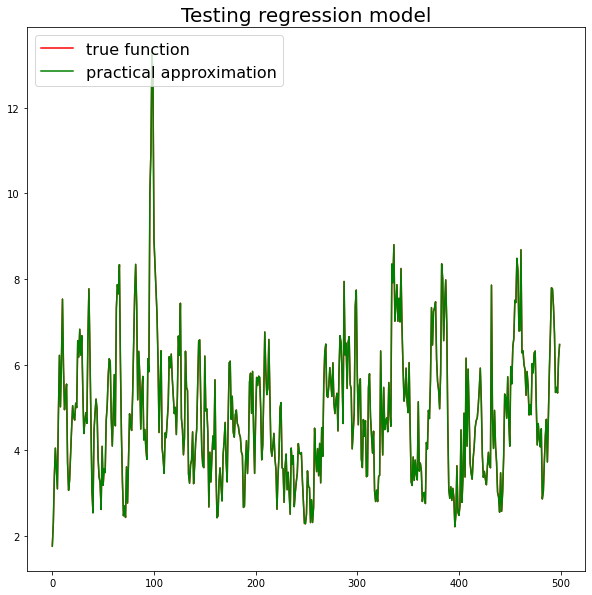

In [34]:
cur_lag = 0
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [35]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

M_n_2: M_n_2:  M_n_2: M_n_2: M_n_2: M_n_2:  M_n_2: M_n_2: M_n_2: M_n_2: -46.55693907728264M_n_2:  M_n_2:  M_n_2: M_n_2: M_n_2:   -31.641165412382694M_n_2:    
 -26.59219424487021M_n_2: -2.069536659065621 M_n_2:   36.4673616400605619.318496684239598  
-33.99474943278837 42.9618553668321M_n_2: M_n_2: 15.8205334931759
-28.469899663994997M_n_1: -3.704768165722268 69.2469917423682-67.19632218443745
 



M_n_1: -12.103829445636714-33.65005303100347
-17.075220096048472 
 
21.71441651847187 
M_n_1: 
 M_n_1: -95.61741755013752M_n_1: 
M_n_1: M_n_1: -2.8782186575568645-40.959505760541056-157.06849769498493M_n_1: M_n_1: M_n_2: 

 M_n_1: 
M_n_2:  M_n_1: 85.67420810801669
M_n_1: M_n_1:    
M_n_1: 

  M_n_1: M_n_1:   M_n_1:  M_n_1:  -65.1736967713759444.29410489797147-41.7680353843392 M_n_2:  117.71253770422294 M_n_1: 173.2409851731226M_n_1: -292.28141769180235  250.9918358776887477.62020738884821 -35.42215113909315 619.9595813296779


-14.546345733257949-174.79233938617313
   323.4780139007416
31.07

In [36]:
res_new = np.asarray(res)
print(res_new.shape)

### Comparison plots

In [41]:
title = ""
labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MAD-CV-1']#, 'Euler scheme \nwith MAD-CV-2']

In [42]:
data = [res_new[:,0],res_new[:,1]]#,res_new[:,2]] 
boxplot_ind(data, title, labels,path="./CIR_linear_02_12.pdf")